<h2>Проект предсказания велечины заработной платы вакансий</h2>

In [10]:
# Основные библиотеки
import copy
import json
import os
import pickle
import re
import time
from collections import Counter

import numpy as np
import pandas as pd
import requests
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
import xgboost

In [3]:
# Функции для получения данных с hh.ru api

def get_page(params: dict, vac: str, page: int = 0) -> str:
    """Получает данные с стайта hh.ru и спользованием API
    на основе заданных параметров"""
    params["page"] = page
    params["text"] = vac
    req = requests.get("https://api.hh.ru/vacancies", params)  # Посылаем запрос к API
    data = (
        req.content.decode()
    )  # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data


def get_additional_information(url: str) -> dict:
    "Выводит дополнительную информацию о вакансии"
    with requests.get(url) as req:
        data = req.content.decode()
    return json.loads(data)


def get_frame_with_salary(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[(df["salary_to"] != 0) & (df["salary_from"] != 0), "salary"] = (
        df["salary_to"] + df["salary_from"]
    ) // 2
    df.loc[df["salary_to"] != 0, "salary"] = df["salary_to"]
    df.loc[(df["salary_to"] == 0) & (df["salary_from"] != 0), "salary"] = df[
        "salary_from"
    ]
    df.loc[(df["salary_to"] == 0) & (df["salary_from"] == 0), "salary"] = 0
    df.loc[df["currency"] == "RUB", "currency_coin"] = 1
    df.loc[df["currency"] == "RUR", "currency_coin"] = 1
    df.loc[df["currency"] == "USD", "currency_coin"] = 78
    df.loc[df["currency"] == "EUR", "currency_coin"] = 83
    df.loc[df["currency"] == "KZT", "currency_coin"] = 0.17
    df.loc[df["currency"].isna(), "currency_coin"] = 0
    df["salary"] = df["salary"] * df["currency_coin"] / 1000
    # df["salary_round"] = df["salary"].apply(lambda x: round(x, -2))

    return df


def get_description_vacancies(json_items: list) -> list:
    """Выводит список словарей, описывающих вакансии
    Функция получения списка описания вакансий по заданным параметрам
    Основные параметры:
    id вакансии
    Название вакансии
    Место расположения офиса (по умолчанию выбран регион - Москва)
    Зарплата от
    Зарплата до
    Валюта
    Компания-работодатель
    График работы"""
    description_vacancies = []
    json_copy = json_items.copy()
    for items in json_copy:
        description = {}
        skills = []
        add_info = get_additional_information(items.get("url"))
        if add_info:
            description["id"] = add_info.get("id", 0)
            description["vacancy"] = add_info.get("name", "unknow")
            description["area"] = (
                add_info.get("area").get("name")
                if add_info.get("area", 0)
                else "unknow"
            )
            description["salary_from"] = (
                add_info.get("salary").get("from", 0)
                if add_info.get("salary", 0)
                else 0
            )
            description["salary_from"] = (
                description["salary_from"] if description["salary_from"] != None else 0
            )
            description["salary_to"] = (
                add_info.get("salary").get("to", 0) if add_info.get("salary", 0) else 0
            )
            description["salary_to"] = (
                description["salary_to"] if description["salary_to"] != None else 0
            )
            description["currency"] = (
                add_info.get("salary").get("currency", "RUB")
                if add_info.get("salary", 0)
                else "RUB"
            )
            description["employer"] = (
                add_info.get("employer").get("name")
                if add_info.get("employer", 0)
                else "unknow"
            )
            description["schedule"] = (
                add_info.get("schedule").get("name")
                if add_info.get("schedule", 0)
                else "unknow"
            )
            description["employment"] = (
                add_info.get("employment").get("name")
                if add_info.get("employment", 0)
                else "unknow"
            )
            description["description"] = add_info.get("description", "unknow")
            if add_info.get("key_skills", 0):
                for skill in add_info.get("key_skills"):
                    if skill.get("name", 0):
                        skills.append(skill.get("name"))
            description["skills"] = ", ".join(skills)
        if description:
            description_vacancies.append(description)

    return description_vacancies


def get_vacancies(only_salary: bool) -> list:
    PARAMS = {
        "area": 1,  # Поиск ощуществляется по вакансиям города Москва
        "per_page": 100,  # Кол-во вакансий на 1 странице
        # "only_with_salary": True,  # Показывать вакансии с известной ЗП
    }
    if only_salary:
        PARAMS["only_with_salary"] = True
    else:
        PARAMS["only_with_salary"] = False
    # VACANCIES = ["Data Science", "Data Scaentst", "ML", "ML engineer", "Big data", "Dev Ops", "DevOps"]
    VACANCIES = ["Python"]
    lst_result = []
    for name in VACANCIES:
        vac = f"NAME:{name}"
        for page in range(0, 7):
            json_obj = json.loads(get_page(PARAMS, vac, page))
            lst_result.append(json_obj)
            time.sleep(0.25)
    vacancies = []
    for items in lst_result:
        vacancy = get_description_vacancies(items["items"])
        if vacancy:
            vacancies = vacancies + vacancy
        time.sleep(0.25)

    df = pd.DataFrame(vacancies)
    df = df.drop_duplicates(keep="first")
    df = get_frame_with_salary(df)
    tags = re.compile(r"<[a-zA-Z /]*>")
    df["description"] = df["description"].apply(lambda x: re.sub(tags, "", x))
    # return df
    return df

<h5>Получим данные загрузим их в датафрейм и посмотрим на них</h5>

In [5]:
df = get_vacancies(True)
df.head()

,id,vacancy,area,salary_from,salary_to,currency,employer,schedule,employment,description,skills,salary,currency_coin
0,54939886,Python разработчик,Москва,0,450000,RUR,Точка,Удаленная работа,Полная занятость,"Ищем опытного питониста, который любит вызовы ...","Python, aiohttp, asyncio, Django Framework, Flask",450.0,1.0
1,48457284,Разработчик Solidity/Разработчик Rust/Разработ...,Москва,600000,0,RUR,ArtVolkov.ru,Гибкий график,Полная занятость,"Что надо будет делать: Проектировать, кодиров...","Английский язык, Rust, Лидерство, golang, go",600.0,1.0
2,55132214,Стажер-разработчик Python,Москва,20000,50000,RUR,Аналитические программные решения,Полный день,Полная занятость,Наша компания занимается разработкой решений в...,"Python, PostgreSQL, MongoDB, REST, HTTP, Git, ...",50.0,1.0
3,54929214,Python Developer,Москва,250000,350000,RUR,АСД Технолоджиз,Полный день,Полная занятость,"АСД Технолоджиз, разработчик платформы cloudik...",,350.0,1.0
4,55202847,Разработчик Python,Москва,100000,200000,RUR,AISA,Полный день,Полная занятость,Мы предлагаем: Обучение построению и использо...,"Python, HTTP, REST, Linux, Docker, Docker-comp...",200.0,1.0


Целевой переменной выступает столбец salary. Посмотрим на его распределение. 

In [66]:
mean = np.round(df["salary"].mean())
median = np.median(df["salary"])

In [68]:
print(f"mean salary: {mean}  median salary:{median}")

mean salary: 254.0  median salary:230.0


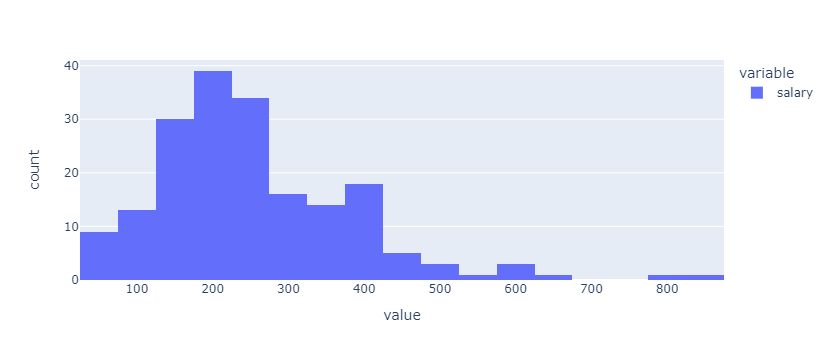

In [22]:
px.histogram(df["salary"],nbins=40)

Видно, что целевая переменная имеет тяжлый правый хвост и в основном ее значения сосредоточены от 100т. до 400т.


<h5>Основные используемые признаки</h5>

In [24]:
df[["vacancy","skills","description","schedule","employment"]]

,vacancy,skills,description,schedule,employment
0,Python разработчик,"Python, aiohttp, asyncio, Django Framework, Flask","Ищем опытного питониста, который любит вызовы ...",Удаленная работа,Полная занятость
1,Разработчик Solidity/Разработчик Rust/Разработ...,"Английский язык, Rust, Лидерство, golang, go","Что надо будет делать: Проектировать, кодиров...",Гибкий график,Полная занятость
2,Стажер-разработчик Python,"Python, PostgreSQL, MongoDB, REST, HTTP, Git, ...",Наша компания занимается разработкой решений в...,Полный день,Полная занятость
3,Python Developer,,"АСД Технолоджиз, разработчик платформы cloudik...",Полный день,Полная занятость
4,Разработчик Python,"Python, HTTP, REST, Linux, Docker, Docker-comp...",Мы предлагаем: Обучение построению и использо...,Полный день,Полная занятость
...,...,...,...,...,...
183,"Веб-программист (Python), удалённо","API, Flask, Django, Git, Asana, amoCRM, Англий...",Здравствуйте! Мы ищем на постоянную удалённую ...,Удаленная работа,Полная занятость
184,Python разработчик (Junior),"Python, HTTP, Docker-compose, SQLAlchemy",Требования: * Знание Python 3 и базовых библио...,Удаленная работа,Полная занятость
185,Python бэкенд-разработчик,"Python, Docker, Django Framework, Git, Linux, ...",Компания занимается разработкой мобильных прил...,Удаленная работа,Полная занятость
186,Начальник отдела разработки программного обесп...,"Организация мероприятий, Разработка инструкций...",Обязанности: - Осуществляет разработку техниче...,Полный день,Полная занятость


<h3>Преобразование данных</h3>

<h5>Навыки</h5>

In [29]:
def get_counter(lst_skills: list) -> Counter:
    """Функция возвращает навыки и количество их встречаемости"""
    set_skills = []
    for skill in lst_skills:
        set_skills = set_skills + skill.split(", ")
    return Counter(set_skills)

In [33]:
# Посмотрим на навыки по числу встречаемости
df_skills = df["skills"].copy()
df_name = df["vacancy"].copy()
list_skills = []
for str_skills in df_skills.values:
    list_skills = list_skills + str_skills.lower().split(", ")
set_skills = sorted(get_counter(list_skills).items(), key=lambda x: x[1], reverse=True)
set_skills = dict(set_skills)
set_skills = {key: value for key, value in set_skills.items() if key != ""}
print(len(set_skills))
set_skills

238


{'python': 164,
 'postgresql': 73,
 'git': 67,
 'django framework': 57,
 'linux': 56,
 'sql': 54,
 'docker': 26,
 'английский язык': 25,
 'django': 23,
 'flask': 20,
 'redis': 19,
 'ооп': 18,
 'mysql': 17,
 'mongodb': 12,
 'rabbitmq': 12,
 'css': 12,
 'javascript': 12,
 'api': 12,
 'html': 11,
 'rest': 10,
 'aiohttp': 9,
 'удаленная работа': 9,
 'celery': 9,
 'java': 8,
 'nginx': 8,
 'kubernetes': 7,
 'asyncio': 6,
 'golang': 6,
 'go': 6,
 'базы данных': 6,
 'c++': 6,
 'nlp': 6,
 'django rest framework': 6,
 'http': 5,
 'docker-compose': 5,
 'fastapi': 5,
 'atlassian jira': 5,
 'rest api': 5,
 'big data': 5,
 'ci/cd': 5,
 'sqlalchemy': 4,
 'bash': 4,
 'react': 4,
 'clickhouse': 4,
 'c/c++': 4,
 'machine learning': 4,
 'backend': 4,
 'работа с базами данных': 4,
 'администрирование серверов linux': 4,
 'алгоритмы': 3,
 'php': 3,
 'nosql': 3,
 'drf': 3,
 'kafka': 3,
 'ms sql': 3,
 'scrum': 3,
 'gitlab': 3,
 'tcp/ip': 3,
 'soap': 3,
 'паттерны проектирования': 2,
 'анализ данных': 2,
 'bl

В итоге получается 238 признаков при 188 сэмплов. По этому я отбразил имеющиеся навыки на выделенные мной навыки.
Эти навыки хранятся в переменной lst_main_skills. Отображение реализуетс через словарь dct_skills

In [35]:
lst_main_skill = [
    "junior_skills",
    "middle_skills",
    "senior_skills",
    "lead_skills",
    "soft_skills",
    "quality_skills",
]

In [36]:
dct_skills = {
    "python": "junior_skills",
    "postgresql": "middle_skills",
    "git": "middle_skills",
    "django framework": "middle_skills",
    "linux": "junior_skills",
    "sql": "junior_skills",
    "docker": "senior_skills",
    "английский язык": "soft_skills",
    "flask": "junior_skills",
    "django": "junior_skills",
    "ооп": "middle_skills",
    "redis": "senior_skills",
    "mysql": "junior_skills",
    "css": "junior_skills",
    "javascript": "middle_skills",
    "rabbitmq": "middle_skills",
    "html": "junior_skills",
    "api": "middle_skills",
    "mongodb": "middle_skills",
    "rest": "senior_skills",
    "удаленная работа": "quality_skills",
    "celery": "middle_skills",
    "kubernetes": "senior_skills",
    "aiohttp": "senior_skills",
    "asyncio": "senior_skills",
    "java": "senior_skills",
    "nginx": "middle_skills",
    "go": "middle_skills",
    "fastapi": "middle_skills",
    "базы данных": "junior_skills",
    "bash": "middle_skills",
    "nlp": "senior_skills",
    "ci/cd": "senior_skills",
    "golang": "middle_skills",
    "http": "junior_skills",
    "atlassian jira": "middle_skills",
    "docker-compose": "middle_skills",
    "machine learning": "middle_skills",
    "big data": "middle_skills",
    "rest api": "middle_skills",
    "backend": "middle_skills",
    "django rest framework": "middle_skills",
    "c++": "middle_skills",
    "ms sql": "junior_skills",
    "c/c++": "middle_skills",
    "nosql": "middle_skills",
    "sqlalchemy": "middle_skills",
    "clickhouse": "middle_skills",
    "работа с базами данных": "junior_skills",
    "soap": "middle_skills",
    "администрирование серверов linux": "middle_skills",
    "алгоритмы": "junior_skills",
    "aws": "middle_skills",
    "react": "junior_skills",
    "pytorch": "senior_skills",
    "orm": "middle_skills",
    "работа в команде": "soft_skills",
    "gitlab": "junior_skills",
    "drf": "middle_skills",
    "scrum": "senior_skills",
    "xml": "junior_skills",
    "vue.js": "middle_skills",
    "tcp/ip": "junior_skills",
    "agile": "middle_skills",
    "субд": "junior_skills",
    "алгоритмы и структуры данных": "middle_skills",
    "паттерны проектирования": "middle_skills",
    "анализ данных": "junior_skills",
    "pandas": "junior_skills",
    "ml": "middle_skills",
    "databases": "junior_skills",
    "data science": "middle_skills",
    "музыка": "soft_skills",
    "стриминг платформы": "senior_skills",
    "etl": "middle_skills",
    "оптимизация кода": "middle_skills",
    "асинхронное программирование": "senior_skills",
    "selenium ide": "middle_skills",
    "numpy": "junior_skills",
    "kafka": "middle_skills",
    "ansible": "middle_skills",
    "grafana": "middle_skills",
    "data engineering": "middle_skills",
    "грамотность": "quality_skills",
    "аналитическое мышление": "quality_skills",
    "kotlin": "middle_skills",
    "ruby": "middle_skills",
    "web": "junior_skills",
    "apache kafka": "middle_skills",
    "php": "middle_skills",
    "qt": "middle_skills",
    "функциональное тестирование": "middle_skills",
    "тестирование": "junior_skills",
    "управление персоналом": "lead_skills",
    "networking": "middle_skills",
    "devops": "middle_skills",
    "teamleading": "lead_skills",
    "pytest": "middle_skills",
    "обучение": "quality_skills",
    "информационные технологии": "junior_skills",
    "преподаватель": "soft_skills",
    "unix": "middle_skills",
    "gitlab ci": "middle_skills",
    "prometheus": "senior_skills",
    "vba": "junior_skills",
    "oracle": "junior_skills",
    "грамотная речь": "quality_skills",
    "контроль исполнения решений": "lead_skills",
    "rust": "senior_skills",
    "лидерство": "lead_skills",
    "администрирование сайтов": "junior_skills",
    "fast api": "middle_skills",
    "c#": "middle_skills",
    "google cloud": "senior_skills",
    "квантовые технологии": "soft_skills",
    "openstack": "middle_skills",
    "software development": "middle_skills",
    "vkontakte api": "middle_skills",
    "парсинг": "middle_skills",
    "agile project management": "senior_skills",
    "tensorflow": "senior_skills",
    "jenkins": "middle_skills",
    "sdet": "senior_skills",
    "dash": "senior_skills",
    "plotly": "middle_skills",
    "html5": "middle_skills",
    "хорошая обучаемость": "quality_skills",
    "руководство командой разработчиков": "lead_skills",
    "заинтересованность": "quality_skills",
    "back-end": "middle_skills",
    "python3": "junior_skills",
    "mariadb": "middle_skills",
    "telegram": "junior_skills",
    "ориентация на результат": "quality_skills",
    "atlassian confluence": "middle_skills",
    "testcomplete": "middle_skills",
    "автоматизированное тестирование": "middle_skills",
    "cucumber": "middle_skills",
    "английский — b2 — средне-продвинутый": "soft_skills",
    "visual studio code": "middle_skills",
    "unit testing": "middle_skills",
    "github": "middle_skills",
    "continuous integration / continious delivery": "senior_skills",
    "управление проектами": "junior_skills",
    "jquery": "junior_skills",
    "mvc": "middle_skills",
    "mssql": "junior_skills",
    "react.js": "junior_skills",
    "гарант": "junior_skills",
    "cmake": "middle_skills",
    "selenium": "middle_skills",
    "appium": "middle_skills",
    "ведение переговоров": "lead_skills",
    "обучение персонала": "lead_skills",
    "с": "middle_skills",
    "qa": "senior_skills",
    "restful": "middle_skills",
    "vue js": "middle_skills",
    "1с программирование": "junior_skills",
    "1с: предприятие 8": "junior_skills",
    "multithreading": "senior_skills",
    "multiprocessing": "senior_skills",
    "python 3": "junior_skills",
    "знания протокола rest": "middle_skills",
    "знания протокола grpc": "senior_skills",
    "знания протокола graphql": "senior_skills",
    "опыт работы с контейнерами": "middle_skills",
    "cmmi": "senior_skills",
    "креативность": "quality_skills",
    "творческое мышление": "quality_skills",
    "аналитика": "soft_skills",
    "elk": "middle_skills",
    "aggregate": "lead_skills",
    "udp": "middle_skills",
    "elasticsearch": "middle_skills",
    "быстрое обучение": "quality_skills",
    "cassandra": "senior_skills",
    "руководство коллективом": "lead_skills",
    "phyton": "middle_skills",
    "angularjs": "senior_skills",
    "angular12": "senior_skills",
    "многозадачность": "quality_skills",
    "киберспорт": "junior_skills",
    "игры": "junior_skills",
    "геймдев": "middle_skills",
    "lead": "lead_skills",
    "architect": "junior_skills",
    "мотивация": "quality_skills",
    "nft": "middle_skills",
    "криптосистемы": "middle_skills",
    "смартпроекты": "middle_skills",
    "blockchain": "senior_skills",
    "smart контракты": "senior_skills",
    "spark": "senior_skills",
    "фильтр частиц": "junior_skills",
    "радиосигналы": "middle_skills",
    "automation testing": "senior_skills",
    "manual testing": "senior_skills",
    "microservices": "senior_skills",
    "teamcity": "senior_skills",
    "нагрузочное тестирование": "middle_skills",
    "регресcионное тестирование": "middle_skills",
    "автотестирование": "middle_skills",
    "yandex.tank": "senior_skills",
    "jmeter": "middle_skills",
    "kibana": "senior_skills",
    "allure test report": "middle_skills",
    "математическая статистика": "middle_skills",
    "портфельные риски": "middle_skills",
    "теория вероятностей": "middle_skills",
    "vue": "middle_skills",
    "bert": "lead_skills",
    "apache ignite": "senior_skills",
    "django orm": "senior_skills",
    "sdk": "senior_skills",
    "computer science": "middle_skills",
    "highload": "senior_skills",
    "frontend": "junior_skills",
    "mercurial": "middle_skills",
    "microsoft access": "junior_skills",
    "разработка нового продукта": "middle_skills",
    "autodesk maya": "junior_skills",
    "autodesk shotgrid": "junior_skills",
    "желание учиться и развиваться": "quality_skills",
    "ruby on rails": "middle_skills",
    "добросовестность": "quality_skills",
    "исполнительность": "quality_skills",
    "инициативность": "quality_skills",
    "swagger": "senior_skills",
    "postgres": "middle_skills",
    "websockets": "senior_skills",
    "sentry": "senior_skills",
    "k8s": "senior_skills",
    "grafana efk": "senior_skills",
    "telegram bots": "senior_skills",
    "threading / multiprocessing в python": "senior_skills",
    "english b1-c2": "soft_skills",
    "r": "junior_skills",
    "web application development": "senior_skills",
    "falcon": "middle_skills",
    "gdal": "middle_skills",
    "pycharm": "junior_skills",
    "json api": "middle_skills",
    "asana": "junior_skills",
    "amocrm": "junior_skills",
    "умение быстро усваивать новую информацию": "quality_skills",
    "firebase": "senior_skills",
    "коммуникабельность": "quality_skills",
    "ответственность": "quality_skills",
    "ответственность и пунктуальность": "quality_skills",
    "умение работать в условиях многозадачности": "quality_skills",
    "работа в условиях многозадачности": "quality_skills",
    "организация мероприятий": "lead_skills",
    "разработка инструкций": "soft_skills",
    "техническая документация": "soft_skills",
    "делопроизводство": "soft_skills",
    "должностные инструкции": "lead_skills",
    "групповое обучение": "quality_skills",
    "обучение и развитие": "quality_skills",
    "организаторские навыки": "quality_skills",
    "#crypto": "senior_skills",
    "#solidity": "senior_skills",
    "pentaho": "senior_skills",
    "smart contract": "senior_skills",
    "solid": "senior_skills",
    "solidity": "senior_skills",
    "symfony": "senior_skills",
    "умение принимать решения": "quality_skills",
    
    "k3s": "senior_skills",
    "rke": "senior_skills",
    
    'android': "junior_skills",
    'angular': "senior_skills",
    'bi': "middle_skills",
    'development': "middle_skills",
    'e-commerce': "middle_skills",
    'flex': "middle_skills",
    'flux': "senior_skills",
    'html/css': "middle_skills",
    'ico': "junior_skills",
    'ios': "junior_skills",
    'jira': "junior_skills",
    'js': "middle_skills",
    'json': "middle_skills",
    'kanban': "middle_skills",
    'less': "middle_skills",
    'openapi': "senior_skills",
    'redmine': "middle_skills",
    'ui': "junior_skills",
    'ux': "middle_skills",
    'автоматизация процессов': "soft_skills",
    'администрирование': "junior_skills",
    'бюджетирование': "soft_skills",
    'высшее образование': "soft_skills",
    'гибкость': "quality_skills",
    'графика': "soft_skills",
    'дизайн': "soft_skills",
    'знание английского': "soft_skills",
    'мобильное приложение': "soft_skills",
    'планирование': "quality_skills",
    'продажи': "junior_skills",
    'скорость': "quality_skills",
    'создание': "soft_skills",
    'техническое задание': "soft_skills",
    'умение работать в режиме многозадачности': "quality_skills",
    'управление командой': "lead_skills",
    'художник': "soft_skills",
    'чат-бот': "soft_skills",
    
    'amazon': "senior_skills",
    'automation': "senior_skills",
    'chef': "middle_skills",
    'ci': "senior_skills",
    'circleci': "senior_skills",
    'design patterns': "senior_skills",
    'ds': "junior_skills",
    'erp': "middle_skills",
    'helm': "senior_skills",
    'hive': "middle_skills",
    'information security': "middle_skills",
    'keras': "senior_skills",
    'management': "lead_skills",
    'marketing': "middle_skills",
    'office': "soft_skills",
    'openshift': "senior_skills",
    'powershell': "middle_skills",
    'recruitment': "junior_skills",
    'restful api': "middle_skills",
    'scala': "senior_skills",
    'sklearn': "senior_skills",
    'scikit-learn': "senior_skills",
    'ssh': "middle_skills",
    'ssis': "senior_skills",
    'terraform': "senior_skills",
    'vmware': "soft_skills",
    'vpn': "soft_skills",
    'windows': "soft_skills",
    'yandex.cloud': "senior_skills",
    'автоматизация': "soft_skills",
    'выполнение поставленных задач': "quality_skills",
    'машинное обучение': "middle_skills",
    'мониторинг': "soft_skills",
    'оптимизация запросов': "soft_skills",
    'с++': "middle_skills",
    'микросервис': 'senior_skills',
}

<h5>График и режим работы</h5>

In [39]:
df[["schedule","employment"]].head()

,schedule,employment
0,Удаленная работа,Полная занятость
1,Гибкий график,Полная занятость
2,Полный день,Полная занятость
3,Полный день,Полная занятость
4,Полный день,Полная занятость


Как видно данные признаки категоаьные, по этому их преобразуем к виду one hot

<h5>Название</h5>

In [41]:
df[["vacancy"]].head()

,vacancy
0,Python разработчик
1,Разработчик Solidity/Разработчик Rust/Разработ...
2,Стажер-разработчик Python
3,Python Developer
4,Разработчик Python


Из названий вакансий можно извлечь уровень разработчика которого ищет работодатель. Список уровней представлен в переменной lst_levels

In [42]:
lst_levels = [
    "начальник", 
    "lead",  
    "техлид", 
    "senior", 
    "ведущий", 
    "middle", 
    "старший", 
    "стажер", 
]

<h4>Преобразуем указанные выше признаки</h4>

In [44]:
def get_count_skills(str_skills: str, dict_skills: dict, main_skill: str) ->int:
    """Возвращает число ключевого нывака main_skill среди всех навыков вакансии"""
    str_skills = str_skills.lower().split(", ")
    count = 0
    for skill in str_skills:
        if skill and dict_skills.get(skill,0):
            if main_skill == dict_skills[skill]:
                count += 1
    return count

In [47]:
def get_count_skills_in_description(str_skills: str, dict_skills: dict, main_skill: str) ->int:
    """Возвращает число ключевого нывака main_skill из описания вакансии"""
    punct = re.compile("[,.()/]")
    str_skills = re.sub(punct, " ", str_skills)
    str_skills = str_skills.lower().split(" ")
    count = 0
    for skill in str_skills:
        if skill and dict_skills.get(skill,0):
            if main_skill == dict_skills[skill]:
                count += 1
    return count

In [49]:
def get_level(str_vacancy:str, lst_level: list) -> str:
    """Возвращает уровень разработчика указанный в названии вакансии, если не указан вернет 'other'"""
    for level in lst_level:
        if level in str_vacancy.lower():
            return level
    else:
        return "other"

In [54]:
df = df[df["skills"] != ""] # Убираем те вакансии для которых не указаны навыки

df_skills = df[["skills","description","vacancy"]].copy()
df_train = pd.DataFrame(df_skills)
df_train["salary"] = df["salary"]
# df_train.loc[df_train["salary"]<50, "salary"] = 50
# df_train.loc[df_train["salary"]>=500, "salary"] = 500
for main_skill in lst_main_skill:
    df_train[main_skill] = df_train["skills"].apply(
        lambda x: get_count_skills(x, dct_skills, main_skill)
    ) + df_train["description"].apply(
        lambda x: get_count_skills_in_description(x, dct_skills, main_skill)
    )
    
lst_col = []
code_oh = OneHotEncoder()
schedule_cat = code_oh.fit_transform(df.schedule.values.reshape(-1, 1))
schedule_cat.todense()
df_train[code_oh.categories_[0]] = schedule_cat.todense()
lst_col = lst_col + list(code_oh.categories_[0])
# code_oh = OneHotEncoder()
employment_cat = code_oh.fit_transform(df.employment.values.reshape(-1, 1))
df_train[code_oh.categories_[0]] = employment_cat.todense()
lst_col = lst_col + list(code_oh.categories_[0])
df_train["level"] = df_train.vacancy.apply(lambda x: get_level(x,lst_levels))
df_train["level1"] = df_train.description.apply(lambda x: get_level(x,lst_levels))
df_train.loc[(df_train["level"]=="other")&(df_train["level1"]=="junior"),"level"]="junior"
df_train.loc[(df_train["level"]=="other")&(df_train["level1"]=="middle"),"level"]="middle"
df_train.loc[(df_train["level"]=="other")&(df_train["level1"]=="senior"),"level"]="senior"
df_train.loc[(df_train["level"]=="other")&(df_train["level1"]=="lead"),"level"]="lead"
# code_oh = OneHotEncoder()
level_cat = code_oh.fit_transform(df_train.level.values.reshape(-1, 1))
level_cat.todense()
df_train[code_oh.categories_[0]] = level_cat.todense()
lst_col = lst_col + list(code_oh.categories_[0])
lst_col #Список новых признаков

['Гибкий график',
 'Полный день',
 'Сменный график',
 'Удаленная работа',
 'Полная занятость',
 'Проектная работа',
 'Стажировка',
 'Частичная занятость',
 'lead',
 'middle',
 'other',
 'senior',
 'ведущий',
 'начальник',
 'стажер',
 'старший',
 'техлид']

<h5>Полученый датафрейм</h5>

In [55]:
df_train.head()

,skills,description,vacancy,salary,junior_skills,middle_skills,senior_skills,lead_skills,soft_skills,quality_skills,...,level1,lead,middle,other,senior,ведущий,начальник,стажер,старший,техлид
0,"Python, aiohttp, asyncio, Django Framework, Flask","Ищем опытного питониста, который любит вызовы ...",Python разработчик,450.0,11,20,8,0,1,0,...,начальник,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Английский язык, Rust, Лидерство, golang, go","Что надо будет делать: Проектировать, кодиров...",Разработчик Solidity/Разработчик Rust/Разработ...,600.0,1,8,4,1,1,0,...,other,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Python, PostgreSQL, MongoDB, REST, HTTP, Git, ...",Наша компания занимается разработкой решений в...,Стажер-разработчик Python,50.0,10,14,7,0,1,1,...,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"Python, HTTP, REST, Linux, Docker, Docker-comp...",Мы предлагаем: Обучение построению и использо...,Разработчик Python,200.0,7,14,8,0,0,1,...,other,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"Python, Английский язык, SQLAlchemy, MongoDB, ...",Ищем людей для разработки технологических пр...,Разработчик бэкэнд (Python),70.0,6,14,1,0,1,1,...,other,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Обучение</h3>

Так как число сэмплов дастаточно не велико, для улучшения качесва модели лучше избавится от шумовых данных ЗП.

Для оценки используется средняя абсолютная ошибка для удобства восприятия.

In [57]:
# Получение новых признаков для обучения
X = df_train[(df_train["salary"] < 400)&(df_train["salary"] >=80)][lst_col+lst_main_skill]
y = df_train[(df_train["salary"] < 400)&(df_train["salary"] >=80)]["salary"]

# Разделение выборки на обучающую и тесстовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

<h5>К-ближайших соседей</h5>

In [59]:
# Создание модели
knn = KNeighborsRegressor(n_neighbors=11, weights="distance", p=2)
# Перекресная проверка
(-1)*cross_val_score(knn, X, y, cv=10, scoring="neg_mean_absolute_error").mean()

58.590116340627915

In [72]:
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
dfp = pd.DataFrame()
dfp["y_true"] = y_test
dfp["y_pred"] = y_pred
dfp["differ"] = y_test - y_pred
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
dfp.head(10)

62.57998871473781
5551.079930147359


,y_true,y_pred,differ
93,300.0,213.642941,86.357059
134,250.0,195.315443,54.684557
18,220.0,197.205624,22.794376
45,180.0,229.944356,-49.944356
174,220.0,262.222390,-42.222390
68,270.0,235.844911,34.155089
129,300.0,218.517017,81.482983
158,260.0,243.411311,16.588689
140,250.0,217.288614,32.711386
75,330.0,256.788237,73.211763


В среднем данная модель занижает ЗП.

<h5>Случайный лес</h5>

In [74]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_features="log2",
    min_samples_leaf=5,
)
(-1)*cross_val_score(rf, X, y, cv=10, scoring="neg_mean_absolute_error").mean()

52.97232386794902

In [77]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
dfp = pd.DataFrame()
dfp["y_true"] = y_test
dfp["y_pred"] = y_pred
dfp["differ"] = y_test - y_pred
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
dfp.head()

54.004314068626954
5546.093922230976


,y_true,y_pred,differ
93,300.0,220.483742,79.516258
134,250.0,217.320326,32.679674
18,220.0,214.117035,5.882965
45,180.0,182.960630,-2.960630
174,220.0,230.676628,-10.676628


Данная можель в среднем предсказывает ЗП лучше, при этом ей хорошо даютс предикты в промежутке 180-25

<h5>Градиентный бустинг</h5>

In [79]:
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    colsample_bytree=0.2,
    learning_rate=0.01,
)
(-1)*cross_val_score(xgb, X, y, cv=10, scoring="neg_mean_absolute_error").mean()

49.07761757400009

In [82]:
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
dfp = pd.DataFrame()
dfp["y_true"] = y_test
dfp["y_pred"] = y_pred
dfp["differ"] = y_test - y_pred
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
dfp.head(10)

52.13441521780832
4938.173906965972


,y_true,y_pred,differ
93,300.0,257.024567,42.975433
134,250.0,222.016190,27.983810
18,220.0,210.987030,9.012970
45,180.0,155.149109,24.850891
174,220.0,237.146484,-17.146484
68,270.0,267.475250,2.524750
129,300.0,192.905136,107.094864
158,260.0,217.796539,42.203461
140,250.0,241.881439,8.118561
75,330.0,233.931549,96.068451


Даная моель уже лучше справляется с более высокими значениями целевой переменной.

<h5>Вывод:</h5>
    В целом ансамблевые модели достаточно не плохоо справились с задачей. Для улучшения качества необходимо больше данных (нужно накопить большую базу вакансий). Так же можно пересмотреть солова отображеия признаков